In [2]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers

from torch import nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, add_special_tokens=False)
bert_model = model_class.from_pretrained(pretrained_weights)
v_size = 768

In [5]:
train_dataset = pd.read_csv('../input/hsemath2020reviews/train.csv')[:10000]
train_dataset['text'] = train_dataset['negative'] + '.' + train_dataset['positive']

In [6]:
train_dataset

,review_id,negative,positive,score,text
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1,There were issues with the wifi connection.No...
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5,TV not working.No Positive
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0,More pillows. Beautiful room Great location L...
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4,Very business. Location
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7,Rooms could do with a bit of a refurbishment ...
...,...,...,...,...,...
9995,1a141afc633613754cd15e681295a346,Very bad neighbourhood Too noisy especially a...,No Positive,5.0,Very bad neighbourhood Too noisy especially a...
9996,1a141d0acbce288f4ec9602e030b13f6,No Negative,Very central,8.3,No Negative. Very central
9997,1a14bc92294d5e2360477b0392a185a8,Lots of drilling work but I was compensated f...,spacious clean rooms,7.9,Lots of drilling work but I was compensated f...
9998,1a151b1ef98c92a7483a26db805e9252,All of our party 6 adults all agreed that des...,Pleasant modern Hotel with excellent location...,7.1,All of our party 6 adults all agreed that des...


In [7]:
train_dataset['len'] = train_dataset['text'].apply(lambda x: len(x.split()))

In [8]:
max(train_dataset['len'])

586

<AxesSubplot:>

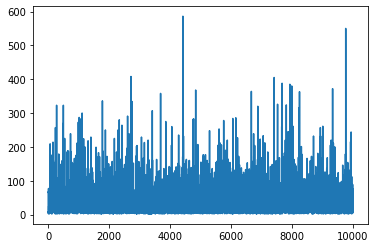

In [9]:
train_dataset['len'].plot()

<AxesSubplot:>

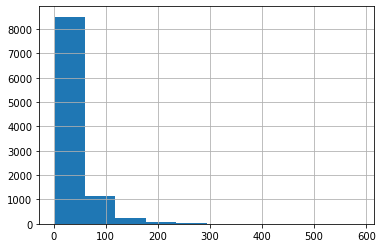

In [10]:
train_dataset['len'].hist()

In [11]:
MAX_LEN = 100
print(len(train_dataset[train_dataset['len']>MAX_LEN]))
print(len(train_dataset[train_dataset['len']>MAX_LEN])/train_dataset.shape[0])

516
0.0516


In [12]:
#test_set = pd.read_csv('test.csv')

In [13]:
train_set, test_set = train_test_split(train_dataset, test_size=0.05)
train_set = train_set.reset_index()
test_set = test_set.reset_index()

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, text_field, target_field):
        
        # храним сырой датасет
        self.dataset = dataset[text_field]
        self.length = dataset.shape[0]
        # таргеты
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

      #можно не токенизировать на лету, а хранить токены

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в вектора, западим и вернем
        text = self.dataset[index]
        tokens = tokenizer(text, return_tensors='pt', padding='max_length', add_special_tokens=False, max_length=MAX_LEN) # токенизируем
        for key in tokens:
          tokens[key] = tokens[key][:, :MAX_LEN] #обрезаем


        y = self.target[index]

        return tokens, y

In [15]:
hid_size = 10

In [16]:
def vectorize(tokens):
    for key in tokens:
    #tokens[key] = torch.squeeze(tokens[key])
        if len(tokens[key].size()) > 2:
            tokens[key] = torch.reshape(tokens[key], (tokens[key].size()[0], tokens[key].size()[2]))
    bert_output = bert_model(**tokens)
    output = bert_output[0]#[:,1:,:] 
    lengths = tokens['attention_mask'].sum(dim=1).to('cpu')
    output.to(device)
    #output = torch.reshape(output, (output.size()[1], output.size()[0], output.size()[2]))
    norm = nn.BatchNorm1d(MAX_LEN)
    output = norm(output)
    #выкинем вектора которые соответствовали «пустышкам»
    output = nn.utils.rnn.pack_padded_sequence(output, lengths, batch_first=True, enforce_sorted=False)
    return output

In [17]:
class my_nn(nn.Module):
    
    def __init__(self, embedder):
        
        super().__init__()          
        self.embedding = embedder
        self.rnn = nn.LSTM(v_size, hid_size, 2, bidirectional=False, dropout=0, batch_first=True)#, nonlinearity='relu')
        self.norm = nn.BatchNorm1d(hid_size)
        self.fc = nn.Linear(hid_size, 1) #*2 если двунаправленная
        
    def forward(self, tokens):
        embedded = self.embedding(tokens)
        rnn = self.rnn(embedded)[0]
        rnn = nn.utils.rnn.pad_packed_sequence(rnn, batch_first=True, padding_value=0.0, total_length=MAX_LEN)
        ran = torch.arange(0, rnn[1].size()[0])
        rnn_last = rnn[0][ran, rnn[1]-1]
        rnn_last = self.norm(rnn_last)
        dense_outputs = self.fc(rnn_last)
        outputs = dense_outputs
        
        return outputs

In [18]:
batch_size = 65

In [19]:
def train(model, iterator, optimizer, criterion, print_every=int(train_dataset.shape[0]/batch_size//10)):
    
    epoch_loss = 0
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        predictions = model(texts).squeeze()
        loss = criterion(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        
        epoch_loss += loss.item()  
        
        if not (i+1) % print_every:
            print(i)
            print(f'Loss: {epoch_loss/i}')
        
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    
    model.train(False)
    model.eval()  
    
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts).squeeze()
            try:
                print(predictions[:10])
            except:
                pass
            loss = criterion(predictions.float(), ys.to(device).float())        

            epoch_loss += loss.item()  
            
    return epoch_loss / len(iterator)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = my_nn(vectorize)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss() 

model = model.to(device)
criterion = criterion.to(device)

In [21]:
training_set = Dataset(train_set, 'text', 'score')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size)

valid_set = Dataset(test_set, 'text', 'score')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)

In [22]:
%%time
loss = []
loss_eval = []
epochs = 5
for i in range(epochs):
    print(i)
    loss.append(train(model, training_generator, optimizer, criterion))
    loss_eval.append(evaluate(model, valid_generator, criterion))

0
14
Loss: 8.881585700171334
29
Loss: 8.608601652342697
44
Loss: 8.492529240521518
59
Loss: 8.395235498072738
74
Loss: 8.348626542735744
89
Loss: 8.30254634042804
104
Loss: 8.249076219705435
119
Loss: 8.20502098067468
134
Loss: 8.155222914112148
tensor([ 0.9408,  0.5981,  1.6559,  0.5529,  1.7553, -0.5120,  2.4787,  0.8919,
         1.4414,  0.4179])
tensor([0.3129, 2.9545, 0.6614, 0.7465, 1.8871, 2.5282, 1.7901, 1.0463, 0.1570,
        0.6412])
tensor([-0.7135,  1.7774,  2.4374,  3.8598,  1.5723,  0.5434, -1.2037,  1.1754,
         1.6447,  1.7155])
tensor([-0.1801,  0.0823,  2.2077,  1.0544,  0.6532, -0.0380,  1.2861,  3.0579,
         0.9265,  0.2351])
tensor([-0.8166,  0.2011, -0.3839,  2.1403,  0.1963,  0.7960,  2.6188,  1.1950,
         0.8100,  0.7458])
tensor([3.1288, 1.6604, 2.6699, 1.6143, 0.4923, 0.2537, 2.0979, 0.4340, 0.7020,
        0.2693])
tensor([ 0.2893, -0.1839,  0.1769,  2.0956, -0.2342, -0.2809,  2.0654,  0.9333,
         1.1804,  0.9199])
tensor([-0.3847,  1.5273,

In [23]:
loss_eval

[7.193577766418457,
 5.659352004528046,
 2.4857378602027893,
 1.0568245351314545,
 1.0370071530342102]